## Загрузка данных

Две ячейки ниже скачивают архив с данными и распаковывают этот архив

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/Ggl9017wNIN0vg) -o simpsons.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  529M  100  529M    0     0  12.3M      0  0:00:42  0:00:42 --:--:-- 14.5M


In [ ]:
! unzip -qq simpsons.zip

Импортируем нужные библиотеки:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
torch.cuda.empty_cache()

In [ ]:
preWeights = models.ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=preWeights)
modTransforms = preWeights.transforms()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 95.5MB/s]


Создадим датасеты из данных. Обратите внимание, что для тестовых данных вам не известны ответы: внутри папки `./simpsons_data/test` нет подпапок с названиями классов, там всего одна папка со всеми изображениями. Ваша задача — обучить нейросеть, используя тренировочные данные, для которых вам известны ответы, получить с помощью обученной нейросети предсказания для тестовых данных и сдать их в качестве ответа.

In [ ]:
train_data = datasets.ImageFolder('./simpsons_data/train', transform=modTransforms)
test_data = datasets.ImageFolder('./simpsons_data/test', transform=modTransforms)

Получим соответствие номеров классов и их названий:

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

Разделим тренировочную выборку на две части: тренировочную и валидационную. На тренировочной части, как обычно, будем обучать нейросеть, а на валидационной будем сеть тестировать.

In [ ]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Создадим три даталоадера для трех частей данных:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

И посмотрим на несколько картинок из обучающей выборки, чтобы понимать, с чем мы имеем дело.

In [ ]:
for batch in test_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [ ]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

Отрисуем картинки. Картинки будут отрисованы уже после преобразований (transforms), поэтому они могут быть не очень естественных цветов, если среди преобразований была нормализация. Не пугайтесь =)

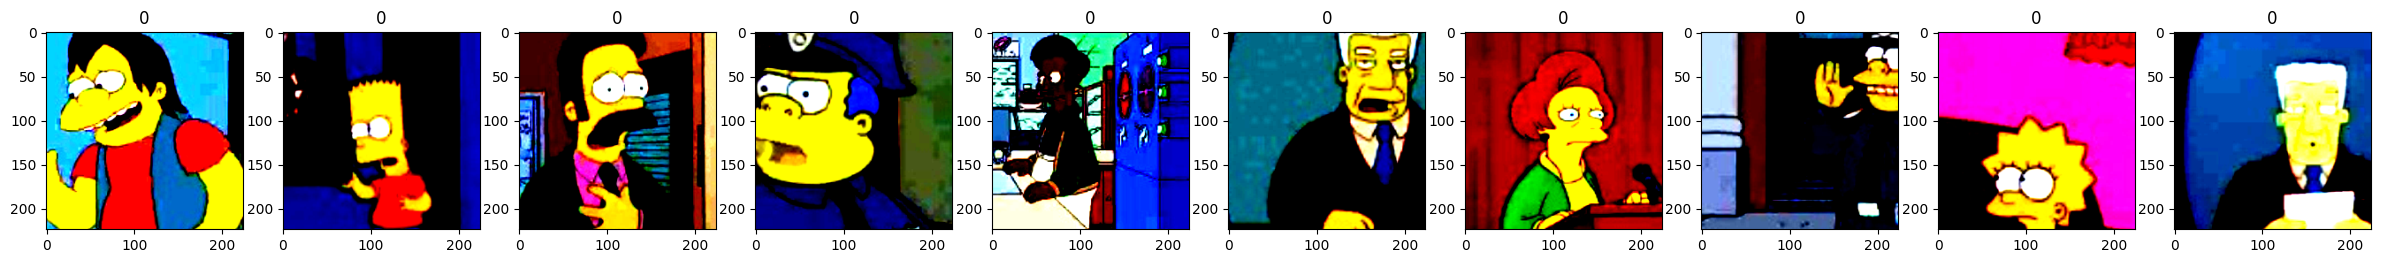

In [ ]:
show_images(images, labels)

Изменение последнего слоя

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=42, bias=True)

## Построение и обучение модели

Замарозка всех слоев кроме последнего

In [ ]:
numTopCh = len(list(model.children()))
print(numTopCh)
children = list(model.children())
ch0 = children[0]
num1Ch = len(list(ch0.children()))
print(num1Ch)

10
0


In [ ]:
numActiveParams = 512*42
totalParams = 512*42
for i, layer in enumerate(children):
  if i < numTopCh-3:
    cnt = 0
    for param in layer.parameters():
      param.requires_grad = False
      cnt = cnt + param.numel()
    totalParams += cnt
  else:
    cnt = 0
    for param in layer.parameters():
      cnt += param.numel()
    numActiveParams += cnt
    totalParams += cnt

----------------

Проверяем, доступен ли GPU (если не доступен, включите GPU в настройках ноутбука):

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def evaluate(model, dataloader, loss_fn):
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

In [ ]:
import torch.optim as optim

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 6e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
from tqdm.notebook import tqdm

In [ ]:
def train(model, loss_fn, optimizer, n_epoch=4, last_epoch=0):
    # цикл обучения сети
    for epoch in range(1+last_epoch, 1+last_epoch+n_epoch):

        print("Epoch:", epoch)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 12 == 0:
                print(f"Train loss = {np.mean(running_losses):.6f}, acc. = {np.mean(running_accuracies):.6f}")

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        print(f"Эпоха {epoch}/{last_epoch+n_epoch}: ", end='', flush=True)
        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print(f"valid loss = {val_loss:.6f}, acc. = {val_accuracy:.6f}")
    return model

In [ ]:
model = train(model, loss_fn, optimizer, n_epoch=15)

Epoch: 1
Train loss = 2.019692, acc. = 0.497396
Train loss = 1.526766, acc. = 0.631510
Train loss = 1.306610, acc. = 0.690104
Train loss = 1.147204, acc. = 0.727539
Train loss = 1.067337, acc. = 0.745052
Train loss = 0.997114, acc. = 0.761285
Train loss = 0.934056, acc. = 0.777344
Train loss = 0.878065, acc. = 0.790202
Train loss = 0.835331, acc. = 0.800637
Train loss = 0.792925, acc. = 0.810807
Train loss = 0.759207, acc. = 0.816761
Train loss = 0.738761, acc. = 0.821506
Train loss = 0.713735, acc. = 0.826623
Train loss = 0.692306, acc. = 0.831473
Train loss = 0.674691, acc. = 0.834983
Train loss = 0.655175, acc. = 0.839518
Train loss = 0.637561, acc. = 0.843367
Train loss = 0.623366, acc. = 0.847078
Train loss = 0.608016, acc. = 0.850329
Train loss = 0.591673, acc. = 0.853776
Train loss = 0.577779, acc. = 0.856957
Эпоха 1/15: valid loss = 0.311849, acc. = 0.920468
Epoch: 2
Train loss = 0.122904, acc. = 0.979167
Train loss = 0.126208, acc. = 0.973307
Train loss = 0.123531, acc. = 0.97

## Получение ответов на тестовую выборку

Функция ниже позволит вам получить ответ вашей модели на тестовую выборку. Файл submission_hw05.npy нужно будет отправить на Я.Контест

In [ ]:
def get_predictions(model, dataloader):

    predicted_labels = []
    model.eval()
    predicted_labels = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, _ = batch

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

# model — переменная, в которой находится ваша модель.
predicted_labels = get_predictions(model, test_loader)
idx_to_class = {y:x for x, y in class_to_idx.items()}
predicted_labels = [idx_to_class[x] for x in predicted_labels.data.cpu().numpy()]

np.save('submission_hw05.npy', predicted_labels, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw05.npy`')

Ответ сохранен в файл `submission_hw05.npy`
